# I. First step : Simple Convolutionnal Neural Network (CNN)

## On MNIST

### Import the library

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

### Collecting the data

In [62]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [63]:
print("shape of train data : " , train_data.data.size())
print("shape of test data : " , test_data.data.size())
print("shape of train labels : " , train_data.targets.size())

shape of train data :  torch.Size([60000, 28, 28])
shape of test data :  torch.Size([10000, 28, 28])
shape of train labels :  torch.Size([60000])


### Preprocessing

In [64]:
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_data,
                         batch_size=128,
                         shuffle=True,
                         num_workers=1),

    'test'  : DataLoader(test_data,
                         batch_size=128,
                         shuffle=True,
                         num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x143d8f0d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x143d8feb0>}

tensor(5)


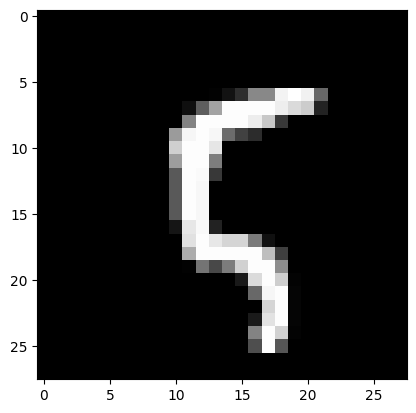

In [65]:
plt.imshow(train_data.data[100],cmap='gray')
print(train_data.targets[100])

### Building the network

In [66]:
import torch.nn as nn
from torch.nn import Sequential,Conv2d,AvgPool2d,Flatten,Linear,Sigmoid

In [67]:
nb_epoch = 20

#Define the model Sequential

model = Sequential(
    Conv2d(in_channels = 1,out_channels = 6,kernel_size = (5,5),padding = 2),
    Sigmoid(),
    AvgPool2d(kernel_size = (2,2),stride = 2),
    Conv2d(in_channels = 6,out_channels = 16,kernel_size = (5,5)),
    Sigmoid(),
    AvgPool2d(kernel_size = (2,2),stride = 2),
    Flatten(),
    Linear(16*5*5,120),
    Sigmoid(),
    Linear(120,84),
    Sigmoid(),
    Linear(84,10)
)

In [68]:
from torchvision import models
from torchsummary import summary
print(model)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Sigmoid()
  (2): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Sigmoid()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Sigmoid()
  (11): Linear(in_features=84, out_features=10, bias=True)
)


In [69]:
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
           Sigmoid-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
           Sigmoid-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
           Flatten-7                  [-1, 400]               0
            Linear-8                  [-1, 120]          48,120
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
---------------------------------

In [70]:
import torch.optim as optim

#Define Loss function and Optimizer :
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [71]:
num_epochs = 20

#Train the model:

def train(num_epochs, cnn, loaders):
    loss_value = np.zeros((20,2))
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(loaders['train'], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if (i+1) % 100 == 0:    # print every 100 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
                running_loss = 0.0
        loss_value[epoch] = [epoch,loss.item()]
    print('Finished Training')
    return loss_value
loss_value  = train(nb_epoch,model, loaders)

[1,   100] loss: 2.308
[1,   200] loss: 2.265
[1,   300] loss: 1.581
[1,   400] loss: 0.937
[2,   100] loss: 0.559
[2,   200] loss: 0.457
[2,   300] loss: 0.412
[2,   400] loss: 0.346
[3,   100] loss: 0.295
[3,   200] loss: 0.282
[3,   300] loss: 0.254
[3,   400] loss: 0.243
[4,   100] loss: 0.214
[4,   200] loss: 0.209
[4,   300] loss: 0.192
[4,   400] loss: 0.194
[5,   100] loss: 0.170
[5,   200] loss: 0.173
[5,   300] loss: 0.164
[5,   400] loss: 0.148
[6,   100] loss: 0.148
[6,   200] loss: 0.141
[6,   300] loss: 0.132
[6,   400] loss: 0.142
[7,   100] loss: 0.129
[7,   200] loss: 0.122
[7,   300] loss: 0.119
[7,   400] loss: 0.118
[8,   100] loss: 0.098
[8,   200] loss: 0.117
[8,   300] loss: 0.118
[8,   400] loss: 0.104
[9,   100] loss: 0.100
[9,   200] loss: 0.102
[9,   300] loss: 0.100
[9,   400] loss: 0.094
[10,   100] loss: 0.090
[10,   200] loss: 0.095
[10,   300] loss: 0.093
[10,   400] loss: 0.086
[11,   100] loss: 0.085
[11,   200] loss: 0.087
[11,   300] loss: 0.076
[11,

In [72]:
#Test the model:

def test(cnn,loaders):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in loaders['test']:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = cnn(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
test(model,loaders)

Accuracy of the network on the 10000 test images: 98.46 %


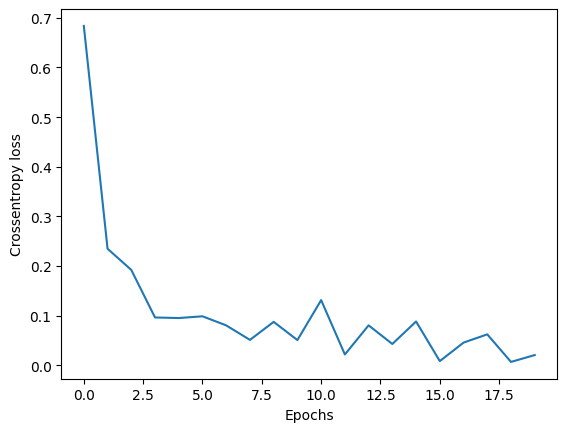

In [73]:
#Plot the loss
plt.plot(loss_value[:,0],loss_value[:,1])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

# II. Second step: Simple Convolutionnal Neural Network on more complex data.

### Load the data

In [106]:
from torch.utils.data import TensorDataset

xTrain = np.load('./pathmnist/test_images.npy')
xTest = np.load('./pathmnist/test_images.npy')
yTrain = np.load('./pathmnist/train_labels.npy')
yTest = np.load('./pathmnist/test_labels.npy')

xTrain = torch.Tensor(xTrain) # transform to torch tensor
yTrain = torch.Tensor(xTest)
xTest = torch.Tensor(xTest)
yTest = torch.Tensor(yTest)
print(xTrain.size())

train_dataset = TensorDataset(xTrain,yTrain) # create your datset
test_dataset = TensorDataset(xTest,yTest)

loaders = {
    'train' : DataLoader(train_dataset,
                         batch_size=128,
                         shuffle=True,
                         num_workers=1),

    'test'  : DataLoader(test_dataset,
                         batch_size=128,
                         shuffle=True,
                         num_workers=1),
}
loaders

torch.Size([7180, 28, 28, 3])


{'train': <torch.utils.data.dataloader.DataLoader at 0x137de66d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x134410c10>}

### Building the network

In [107]:
from torch import sigmoid,flatten

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(in_channels = 3,out_channels = 6,kernel_size = (5,5),padding = 2)
        self.pool = AvgPool2d(kernel_size = (2,2),stride = 2)
        self.conv2 = Conv2d(in_channels = 6,out_channels = 16,kernel_size = (5,5))
        self.fc1 = Linear(16 * 5 * 5, 120)
        self.fc2 = Linear(120, 84)
        self.fc3 = Linear(84, 10)

    def forward(self, x):
        x = self.pool(sigmoid(self.conv1(x)))
        x = self.pool(sigmoid(self.conv2(x)))
        x = flatten(x,1) # flatten all dimensions except batch
        x = sigmoid(self.fc1(x))
        x = sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

model = Net()

In [108]:
print(model)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [109]:
summary(model,(3,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [110]:
loss_value  = train(nb_epoch,model,loaders)
test(model,loaders)

RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[128, 28, 28, 3] to have 3 channels, but got 28 channels instead

In [ ]:
#Plot the loss
plt.plot(loss_value[:,0],loss_value[:,1])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()